# Experiment: Direct LM Head Noise with New Formula

**Setup:**
- Forward  → hidden
- Apply same level of noise to lm head

**Formula:**
$$T^* = T_{base} \times (1 + \alpha)$$


In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from transformers import AutoModelForCausalLM, AutoTokenizer

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("Imports loaded!")

Imports loaded!


In [2]:
# ============================================================
# LOAD MODEL
# ============================================================

MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
T_BASE = 0.8

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,
    device_map="auto"
)
model.eval()

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Model loaded on {model.device}")
print(f"T_base = {T_BASE}")

Loading deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on cuda:0
T_base = 0.8


In [3]:
# ============================================================
# HOOKS - CAPTURE HIDDEN BEFORE LM HEAD
# ============================================================

class HiddenStateCapture:
    def __init__(self):
        self.hidden = None
        
    def hook(self, module, input, output):
        # input[0] is the hidden state before LM head
        self.hidden = input[0].detach().clone()


def get_hidden_before_lm_head(model, tokenizer, prompt):
    """Get hidden states right before LM head (clean forward)."""
    capture = HiddenStateCapture()
    handle = model.lm_head.register_forward_hook(capture.hook)
    
    try:
        inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
        with torch.no_grad():
            outputs = model(inputs.input_ids)
        return capture.hidden, outputs.logits
    finally:
        handle.remove()


def get_logits_with_manual_noise(model, tokenizer, prompt, noise_scale):
    """
    1. Clean forward → get hidden
    2. Add manual noise to hidden
    3. Apply LM head manually
    
    noise_scale is RELATIVE to hidden.std()
    """
    # Clean forward
    hidden, _ = get_hidden_before_lm_head(model, tokenizer, prompt)
    
    # Manual noise (relative to hidden std)
    noise = torch.randn_like(hidden) * noise_scale * hidden.std()
    noisy_hidden = hidden + noise
    
    # Manual LM head
    with torch.no_grad():
        clean_logits = model.lm_head(hidden)
        noisy_logits = model.lm_head(noisy_hidden)
    
    # Return last position
    return clean_logits[0, -1, :], noisy_logits[0, -1, :], hidden[0, -1, :]


# Test
print("Testing...")
test_prompt = "What is 2+2?"
clean_logits, noisy_logits, hidden = get_logits_with_manual_noise(model, tokenizer, test_prompt, 0.1)
print(f"Hidden shape: {hidden.shape}")
print(f"Hidden std: {hidden.std():.4f}")
print(f"Clean logits std: {clean_logits.std():.4f}")
print(f"Noisy logits std: {noisy_logits.std():.4f}")
print("OK!")

Testing...
Hidden shape: torch.Size([1536])
Hidden std: 2.6892
Clean logits std: 1.9588
Noisy logits std: 1.9988
OK!


In [4]:
# ============================================================
# HELPER FUNCTIONS
# ============================================================

def compute_var_p(logits):
    """Compute Var_p(z) - softmax weighted variance."""
    p = F.softmax(logits, dim=-1)
    E_z = (p * logits).sum()
    E_z2 = (p * logits**2).sum()
    return (E_z2 - E_z**2).item()


def compute_alpha(clean_logits, noisy_logits):
    """Compute α = σ²/τ² in logit space."""
    diff = noisy_logits - clean_logits
    sigma_sq = diff.var().item()
    tau_sq = clean_logits.var().item()
    return sigma_sq / tau_sq if tau_sq > 0 else 0


def find_optimal_T(clean_logits, noisy_logits, T_base, temps):
    """Find T that minimizes KL divergence."""
    clean_probs = F.softmax(clean_logits / T_base, dim=-1)
    
    best_t = temps[0]
    best_kl = float('inf')
    
    for t in temps:
        noisy_probs = F.softmax(noisy_logits / t, dim=-1)
        kl = F.kl_div(noisy_probs.log(), clean_probs, reduction='sum').item()
        if kl < best_kl:
            best_kl = kl
            best_t = t
    
    return best_t, best_kl

print("Helpers ready!")

Helpers ready!


In [5]:
# ============================================================
# TEST PROMPTS
# ============================================================

test_prompts = [
    "What is 15 + 27?",
    "Calculate 8 × 7.",
    "If I have 50 apples and give away 23, how many do I have left?",
    "What is the capital of France?",
    "Explain photosynthesis in one sentence.",
    "What is 144 divided by 12?",
    "Name the largest planet in our solar system.",
    "What is 3² + 4²?",
    "How many days are in a leap year?",
    "What is 1000 - 789?",
]

print(f"Test prompts: {len(test_prompts)}")

Test prompts: 10


In [6]:
# ============================================================
# MAIN EXPERIMENT
# ============================================================

noise_scales = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
temperatures = np.arange(0.5, 3.0, 0.01).tolist()
num_samples = 5  # Per prompt per noise level

print("="*80)
print("EXPERIMENT: Direct LM Head Noise")
print("="*80)
print(f"T_base = {T_BASE}")
print(f"Noise scales: {noise_scales}")
print(f"Samples per prompt: {num_samples}")
print()

results = []

for noise_scale in noise_scales:
    print(f"\nNoise scale σ = {noise_scale}")
    
    all_alpha = []
    all_t_actual = []
    all_t_new = []
    all_t_old = []
    all_best_kl = []
    
    for prompt in test_prompts:
        for _ in range(num_samples):
            # Get clean and noisy logits
            clean_logits, noisy_logits, hidden = get_logits_with_manual_noise(
                model, tokenizer, prompt, noise_scale
            )
            
            # Compute α in logit space
            alpha = compute_alpha(clean_logits, noisy_logits)
            
            # Predictions
            t_new = T_BASE * (1 + alpha)           # New formula
            t_old = T_BASE * np.sqrt(1 + alpha)   # Old formula
            
            # Find actual optimal T
            t_actual, best_kl = find_optimal_T(clean_logits, noisy_logits, T_BASE, temperatures)
            
            all_alpha.append(alpha)
            all_t_actual.append(t_actual)
            all_t_new.append(t_new)
            all_t_old.append(t_old)
            all_best_kl.append(best_kl)
    
    results.append({
        'noise_scale': noise_scale,
        'alpha': np.mean(all_alpha),
        't_actual': np.mean(all_t_actual),
        't_new': np.mean(all_t_new),
        't_old': np.mean(all_t_old),
        'best_kl': np.mean(all_best_kl),
    })
    
    print(f"  α = {np.mean(all_alpha):.4f}")
    print(f"  T* actual = {np.mean(all_t_actual):.4f}")
    print(f"  T* new (1+α) = {np.mean(all_t_new):.4f}")
    print(f"  T* old (√) = {np.mean(all_t_old):.4f}")
    print(f"  Best KL = {np.mean(all_best_kl):.6f}")

EXPERIMENT: Direct LM Head Noise
T_base = 0.8
Noise scales: [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
Samples per prompt: 5


Noise scale σ = 0.05
  α = 0.0056
  T* actual = 0.8010
  T* new (1+α) = 0.8045
  T* old (√) = 0.8022
  Best KL = 0.012896

Noise scale σ = 0.1
  α = 0.0225
  T* actual = 0.8182
  T* new (1+α) = 0.8180
  T* old (√) = 0.8089
  Best KL = 0.048354

Noise scale σ = 0.15
  α = 0.0501
  T* actual = 0.8410
  T* new (1+α) = 0.8401
  T* old (√) = 0.8198
  Best KL = 0.109725

Noise scale σ = 0.2
  α = 0.0902
  T* actual = 0.8696
  T* new (1+α) = 0.8722
  T* old (√) = 0.8353
  Best KL = 0.220776

Noise scale σ = 0.25
  α = 0.1391
  T* actual = 0.8948
  T* new (1+α) = 0.9113
  T* old (√) = 0.8538
  Best KL = 0.314638

Noise scale σ = 0.3
  α = 0.2015
  T* actual = 0.9428
  T* new (1+α) = 0.9612
  T* old (√) = 0.8769
  Best KL = 0.447782

Noise scale σ = 0.35
  α = 0.2668
  T* actual = 0.9804
  T* new (1+α) = 1.0134
  T* old (√) = 0.9003
  Best KL = 0.571939

Noise scale σ

In [7]:
# ============================================================
# SUMMARY TABLE
# ============================================================

print("\n" + "="*95)
print("SUMMARY")
print("="*95)
print(f"T_base = {T_BASE}")
print()
print(f"{'σ':<8} {'α':<10} {'T*actual':<10} {'New(1+α)':<10} {'Old(√)':<10} {'Err_new':<10} {'Err_old':<10} {'Winner'}")
print("-"*90)

for r in results:
    err_new = abs(r['t_new'] - r['t_actual'])
    err_old = abs(r['t_old'] - r['t_actual'])
    winner = 'NEW' if err_new < err_old else 'OLD'
    print(f"{r['noise_scale']:<8.2f} {r['alpha']:<10.4f} {r['t_actual']:<10.4f} "
          f"{r['t_new']:<10.4f} {r['t_old']:<10.4f} {err_new:<10.4f} {err_old:<10.4f} {winner}")

print()
print("MEAN ERRORS:")
err_new_mean = np.mean([abs(r['t_new'] - r['t_actual']) for r in results])
err_old_mean = np.mean([abs(r['t_old'] - r['t_actual']) for r in results])
print(f"  New (1+α): {err_new_mean:.4f}")
print(f"  Old (√):   {err_old_mean:.4f}")
print(f"  Ratio:     {err_old_mean/err_new_mean:.2f}x" if err_new_mean > 0 else "")
print(f"  Winner:    {'NEW' if err_new_mean < err_old_mean else 'OLD'}")


SUMMARY
T_base = 0.8

σ        α          T*actual   New(1+α)   Old(√)     Err_new    Err_old    Winner
------------------------------------------------------------------------------------------
0.05     0.0056     0.8010     0.8045     0.8022     0.0035     0.0012     OLD
0.10     0.0225     0.8182     0.8180     0.8089     0.0002     0.0093     NEW
0.15     0.0501     0.8410     0.8401     0.8198     0.0009     0.0212     NEW
0.20     0.0902     0.8696     0.8722     0.8353     0.0026     0.0343     NEW
0.25     0.1391     0.8948     0.9113     0.8538     0.0165     0.0410     NEW
0.30     0.2015     0.9428     0.9612     0.8769     0.0184     0.0659     NEW
0.35     0.2668     0.9804     1.0134     0.9003     0.0330     0.0801     NEW
0.40     0.3656     1.0384     1.0925     0.9347     0.0541     0.1037     NEW

MEAN ERRORS:
  New (1+α): 0.0161
  Old (√):   0.0446
  Ratio:     2.76x
  Winner:    NEW


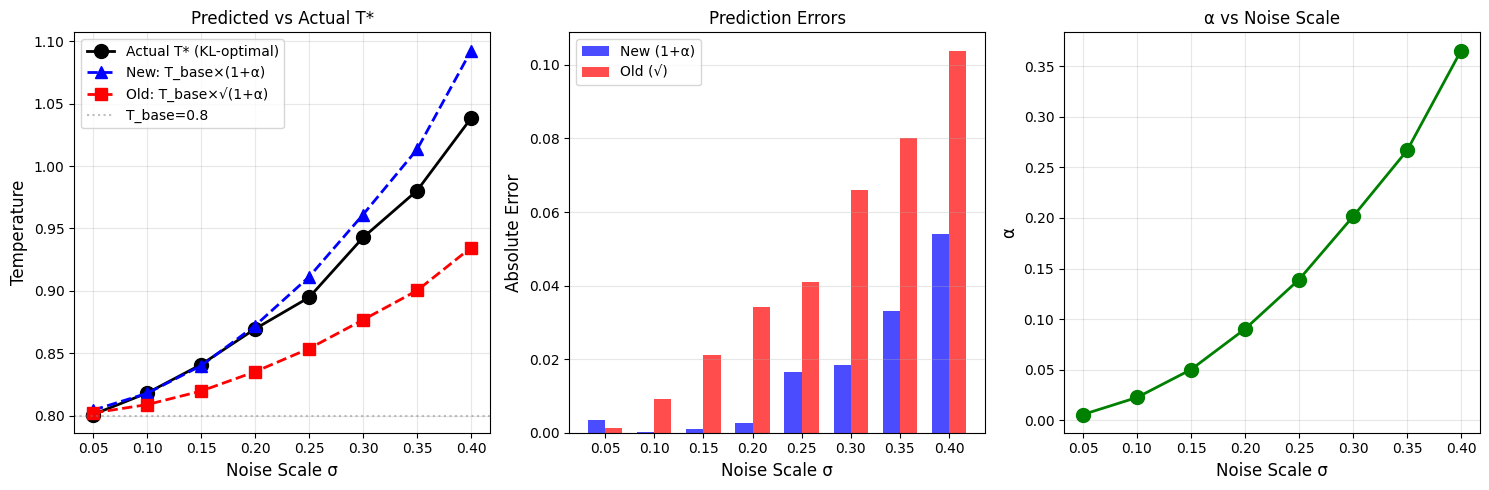

In [8]:
# ============================================================
# PLOT
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

noise_scales_plot = [r['noise_scale'] for r in results]
t_actuals = [r['t_actual'] for r in results]
t_news = [r['t_new'] for r in results]
t_olds = [r['t_old'] for r in results]
alphas = [r['alpha'] for r in results]

# Left: T* comparison
ax1 = axes[0]
ax1.plot(noise_scales_plot, t_actuals, 'ko-', linewidth=2, markersize=10, label='Actual T* (KL-optimal)')
ax1.plot(noise_scales_plot, t_news, 'b^--', linewidth=2, markersize=8, label='New: T_base×(1+α)')
ax1.plot(noise_scales_plot, t_olds, 'rs--', linewidth=2, markersize=8, label='Old: T_base×√(1+α)')
ax1.axhline(y=T_BASE, color='gray', linestyle=':', alpha=0.5, label=f'T_base={T_BASE}')
ax1.set_xlabel('Noise Scale σ', fontsize=12)
ax1.set_ylabel('Temperature', fontsize=12)
ax1.set_title('Predicted vs Actual T*', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Middle: Errors
ax2 = axes[1]
err_new = [abs(r['t_new'] - r['t_actual']) for r in results]
err_old = [abs(r['t_old'] - r['t_actual']) for r in results]
x = np.arange(len(results))
width = 0.35
ax2.bar(x - width/2, err_new, width, label='New (1+α)', color='blue', alpha=0.7)
ax2.bar(x + width/2, err_old, width, label='Old (√)', color='red', alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels([f'{s:.2f}' for s in noise_scales_plot])
ax2.set_xlabel('Noise Scale σ', fontsize=12)
ax2.set_ylabel('Absolute Error', fontsize=12)
ax2.set_title('Prediction Errors', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Right: α vs noise scale
ax3 = axes[2]
ax3.plot(noise_scales_plot, alphas, 'go-', linewidth=2, markersize=10)
ax3.set_xlabel('Noise Scale σ', fontsize=12)
ax3.set_ylabel('α', fontsize=12)
ax3.set_title('α vs Noise Scale', fontsize=12)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('direct_lm_head_new_formula.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# ============================================================
# DETAILED ANALYSIS: T* vs α
# ============================================================

print("\nDetailed: T* / T_base vs α")
print("="*60)
print(f"{'α':<10} {'T*/T_base':<12} {'1+α':<10} {'√(1+α)':<10} {'Closest'}")
print("-"*60)

for r in results:
    ratio = r['t_actual'] / T_BASE
    pred_new = 1 + r['alpha']
    pred_old = np.sqrt(1 + r['alpha'])
    
    err_new = abs(ratio - pred_new)
    err_old = abs(ratio - pred_old)
    closest = 'NEW' if err_new < err_old else 'OLD'
    
    print(f"{r['alpha']:<10.4f} {ratio:<12.4f} {pred_new:<10.4f} {pred_old:<10.4f} {closest}")


Detailed: T* / T_base vs α
α          T*/T_base    1+α        √(1+α)     Closest
------------------------------------------------------------
0.0056     1.0013       1.0056     1.0028     OLD
0.0225     1.0228       1.0225     1.0112     NEW
0.0501     1.0513       1.0501     1.0247     NEW
0.0902     1.0870       1.0902     1.0441     NEW
0.1391     1.1185       1.1391     1.0673     NEW
0.2015     1.1785       1.2015     1.0961     NEW
0.2668     1.2255       1.2668     1.1255     NEW
0.3656     1.2980       1.3656     1.1686     NEW


## Summary

**Setup:**
- Clean forward → get hidden before LM head
- Add manual noise to hidden
- Apply LM head manually
- NO noise in the model itself

**Formulas tested:**
- New: $T^* = T_{base} \times (1 + \alpha)$
- Old: $T^* = T_{base} \times \sqrt{1 + \alpha}$

Where $\alpha = \sigma^2_{noise} / \tau^2_{signal}$ in logit space.